#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Final Exam
### Due: Monday, May 2nd at 4.00pm CST


---

In [506]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import emcee
from scipy import stats

## Problem 1

A model with 10 parameters describes the statistics of the temperature fluctuations
of the Cosmic Microwave Background. We fit this model to 45 published data points of the
variance of the fluctuations as a function of angular scale and find χ2 = 52.7. We then set 5
of the model parameters to zero and fit the model again, this time getting χ2 = 54. Were we
justified in using all 10 parameters in the model?


### Solution

In [502]:
print(f'Percent change in accuracy: {(np.abs(1 - (54 / 52.7)) * 100):.2f}%')

Percent change in accuracy: 2.47%


In [574]:
# Calculate chi-squared per degree of freedom

# Degree of freedom is N - k
dof_10 = 35
dof_5 = 40

print(f'χ2 per d.o.f. for 10 parameters: {(1 / dof_10) * 52.7:.4f}')
print(f'χ2 per d.o.f. for 5 parameters: {(1 / dof_5) * 54:.4f}')

χ2 per d.o.f. for 10 parameters: 1.5057
χ2 per d.o.f. for 5 parameters: 1.3500


To answer this question, I will use the principle of Occam's Razor. When applied to statistics, Occam's Razor says that if each model is in fair agreement with the data, then the less complex model should be favored. In this case, the less complex model is the one with fewer free parameters (5 vs. 10).

The model with 10 free parameters did fit the data points slightly better, but only by around 2.5 percent. In most cases, this very small increase in accuracy is not worth the resources needed for a model with five more parameters. In addition, the χ2 per degree of freedom is larger for the model with 10 parameters than it is for the model with only five. This shows me that the amount of error per dimension is actually higher in the model with more parameters even though the overall χ2 error is less.

Occam's Razor and the calculations for χ2 per degree of freedom tell me that we were not justified in using all 10 parameters. Since both models fit the data with around the same accuracy, the model with only five parameters is preferred.

## Problem 2

Explain what Malmquist bias is. Use the Malmquist bias to explain how it can fool the unwary astronomer into thinking that stellar or galaxy luminosities measured at different wavelengths can appear correlated, even if there is no true correlation.

### Solution

Malmquist bias is an example of how Bayesian priors might have important consequences. Astronomical surveys are magnitude-limited. As we look to greater distances in the sky, the luminosity threshold to detect an object increases. In other words, there is a direct relationship between distance and how bright an object must be in order for our observational instruments to detect it.

We might see many high luminosity objects, but we miss the more numerous low luminosity objects because our tools do not see them. Malmquist bias is the tendency for the mean absolute magnitude of an observed sample to be brighter than the mean absolute magnitude of the population.

Malmquist bias can trick an astronomer into believing that stellar or galactic luminosities measured at different wavelengths are correlated when there is, in fact, no relationship. Because higher luminosity objects can be detected at greater distances than dimmer objects, the Malmquist bias makes it appear as if more luminous objects are, on average, farther away. This creates a spurious correlation between luminosity and distance. This is true for luminosity at any wavelength.

Although luminosities in different wavelength bands are intrinsic stellar properties and independent of each other, Malmquist bias can make it seem like objects that are highly luminous in one wavelength are also highly luminous in another. This is because the luminosity at both of the wavelengths has a perceived relationship with distance.

For example, we might find a distant object that is extremely luminous in both radio and X-ray wavelengths. This might make us assume that the two are correlated, but we must be wary. There could be other objects at the same distance that are extremely luminous in radio, but rather dim in X-ray. If the object was dim enough in X-ray so as to not be detected, this object would not make it into our study at all. We might conclude that there is a direct relationship between radio and X-ray luminosities that isn't really there.

## Problem 3

1) Read in final_data_3.npy. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (not the log posterior) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized.

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. Also find the MAP value of the mean.

### Solution

In [225]:
# Step 1
# Read in data
data = np.load('final_data_3.npy')
data

array([[4.36, 2.24],
       [4.  , 1.94],
       [4.87, 1.39],
       [5.64, 2.55],
       [6.14, 1.69],
       [5.92, 1.38],
       [3.93, 1.  ],
       [6.58, 1.6 ],
       [3.78, 1.  ],
       [5.84, 1.  ]])

In [485]:
# Define some variables to help me later
N = data.shape[0]
V = data[:,0]
e = data[:,1] #Uncertainties

In [366]:
# Compute sample mean
mean = np.mean(V)
print('Sample Mean:', mean)

# Compute standard deviation
std = np.std(V)
print('Sample Standard Deviation:', std)

# Compute standard error on sample mean
# Given by sample standard deviation / square root of N
std_err = (std / math.sqrt(10))
print(f'Standard Error on Sample Mean: {std_err:.5f}')

Sample Mean: 5.106
Sample Standard Deviation: 0.9851416141854935
Standard Error on Sample Mean: 0.31153


In [469]:
# Step 2
# Frequentist Approach (from Lecture 5)

print('Using Frequentist Approach:')

w = 1. / e ** 2
print("""
      Voltage Estimate  = {0:.4f} +/- {1:.4f} (based on {2} measurements)
      """.format((w * voltage).sum() / w.sum(), w.sum() ** -0.5, N))

Using Frequentist Approach:

      Voltage Estimate  = 4.9421 +/- 0.4302 (based on 10 measurements)
      


In [470]:
# Bayesian Approach using MCMC (from Lecture 6)

def log_prior(theta):
    # Mean should be between 3 and 7
    if 3 <= theta[0] <= 7:
        return 1
    else:
        return 0

def log_likelihood(theta, V, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (V - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, V, e):
    return log_prior(theta) + log_likelihood(theta, V, e)

In [473]:
ndim = 1
nwalkers = 50
nburn = 1000
nsteps = 2000

starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[V, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain
sample = sampler.chain[:, nburn:, :].ravel()

mean_est = sample.mean()
std_est = sample.std()

print('Using Bayesian Approach:')
print("""
      Voltage Estimate  = {0:.4f} +/- {1:.4f} (based on {2} measurements)
      """.format(mean_est, std_est, N))

Using Bayesian Approach:

      Voltage Estimate  = 4.9461 +/- 0.4331 (based on 10 measurements)
      


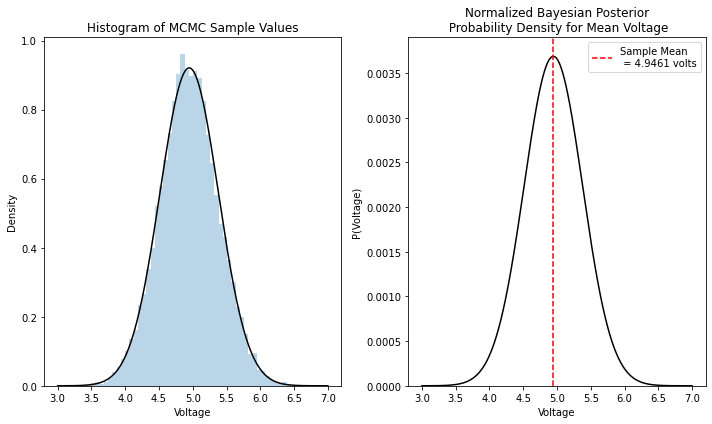

In [474]:
# Step 3
# To plot the Bayesian posterior probability density, I will use the 
# sample array from Step 2 (MCMC)
# Code sourced from Lecture 6

fig, ax = plt.subplots(1, 2, figsize=(10,6))

# Plot a histogram of the sample
# Set density=True for probability
ax[0].hist(sample, bins=50, histtype="stepfilled", 
         alpha=0.3, density=True)
ax[0].set_xlabel('Voltage')
ax[0].set_ylabel('Density')
ax[0].set_title('Histogram of MCMC Sample Values')

# Get the best-fit Gaussian
V_fit = np.linspace(3, 7, 1000)
pdf_raw = stats.norm(mean_est, std_est).pdf(V_fit)

# Plot unnormed PDF to see fit on histogram
ax[0].plot(V_fit, pdf_raw, '-k')

# Normalize the pdf and plot on second axis
pdf = pdf_raw / pdf_raw.sum()
ax[1].plot(V_fit, pdf, '-k')
ax[1].set_xlabel('Voltage')
ax[1].set_ylabel('P(Voltage)')
ax[1].set_title('Normalized Bayesian Posterior\n Probability Density for Mean Voltage')
ax[1].set_ylim(0, 0.0039)
ax[1].axvline(mean_est, c='r', linestyle='--',
            label=f'Sample Mean\n = {mean_est:.4f} volts')
ax[1].legend()

plt.tight_layout()
plt.show()

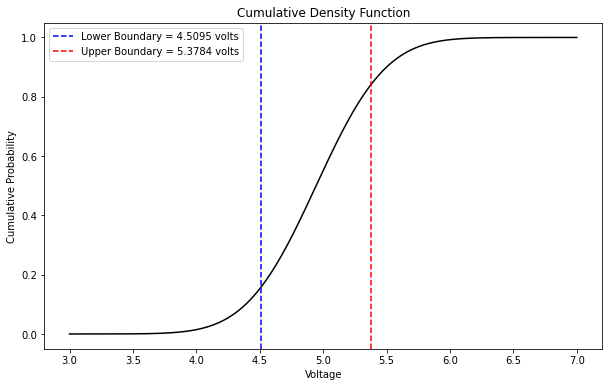

Using CDF Approach:

       Lower Bound: 4.5095    
       Upper Bound: 5.3784
      


In [483]:
# Step 4

# Get CDF using cumsum()
cdf = np.cumsum(pdf)

# Plot CDF to visualize
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(V_fit, cdf, '-k')

# Compute quantile values so that credible region is size 0.683
lower = (1 - .683) / 2
upper = 1 - lower

# Compute quantiles
# Get the index of the value in cdf that is closest to lower. 
# Then return the value at that index in V_fit
# Repeat for upper
lower_bound = V_fit[(np.abs(cdf - lower)).argmin()]
upper_bound = V_fit[(np.abs(cdf - upper)).argmin()]

plt.axvline(lower_bound, c='b', linestyle='--',
            label=f'Lower Boundary = {lower_bound:.4f} volts')
plt.axvline(upper_bound, c='r', linestyle='--',
            label=f'Upper Boundary = {upper_bound:.4f} volts')
plt.legend()
plt.xlabel('Voltage')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Density Function')

plt.show()

print('Using CDF Approach:')
print(f"""
       Lower Bound: {lower_bound:.4f}    
       Upper Bound: {upper_bound:.4f}
      """)

In [476]:
# Another method using scipy.stats

bounds = stats.norm.ppf([lower, upper], mean_est, std_est) 
low_bound, up_bound = bounds[0], bounds[1]

print('Using ppf() Approach:')
print(f"""
       Lower Bound: {low_bound:.4f}      
       Upper Bound: {up_bound:.4f}
      """)

Using ppf() Approach:

       Lower Bound: 4.5127      
       Upper Bound: 5.3795
      


###### As expected, the boundaries I get using the CDF are extremely similar to those I get using the ppf() function. However, because the values in the CDF might not match up exactly with the quantiles, I will make a comparison using the values from the ppf() method.

In [477]:
# Compare the upper and lower boundaries to the sample mean +/- standard error

mean_minus = mean - std_err
mean_plus = mean + std_err

print(f"""
       Lower Bound: {low_bound:.4f} volts      
       Sample Mean - Standard Error: {mean_minus:.4f} volts
       Difference: {low_bound - mean_minus:.4f} volts
      """)

print(f"""
       Upper Bound: {up_bound:.4f} volts      
       Sample Mean + Standard Error: {mean_plus:.4f} volts
       Difference: {up_bound - mean_plus:.4f} volts
      """)


       Lower Bound: 4.5127 volts      
       Sample Mean - Standard Error: 4.7945 volts
       Difference: -0.2818 volts
      

       Upper Bound: 5.3795 volts      
       Sample Mean + Standard Error: 5.4175 volts
       Difference: -0.0380 volts
      


###### The upper bound that I computed was pretty close to the mean plus the standard error. However, the lower bound I computed was much further away.  In fact, the difference of my lower bound was over 7 times that of the upper bound.

###### This difference could be due to how standard error is calculated. The Bayesian pdf took uncertainties into account, but the calculation for standard error does not.

In [486]:
# Find the MAP value of the mean
# The MAP (maximum a posteriori) estimate maximizes the pdf and
# is the natural analog to the maximum likelihood estimate (MLE)

# I will compute by finding the index of the maximum value of the pdf
# Then, I will return the value at that index in V_fit

# Value will not perfectly match the sample mean because V_fit cannot hold every possible
# value for voltage, but it should be extremely close.

print(f'MAP Value of the Mean: {V_fit[np.argmax(pdf)]:.4f} volts')

MAP Value of the Mean: 4.9459 volts


## Problem 4

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data.

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.


In [530]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X_raw = np.column_stack([data[key] for key in keylist])

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to features. What is the explained variance of the data encapsulated in these eigen-features?

3. 
    Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.

4. Choose 5000 random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these 5000 random samples, colored by their corresponding type. (You may want to set the transparency to be lower than 1 to see the mixing of samples.)


5.  Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the 5000 random samples identified in the previous part.

* Try LocallyLinearEmbedding, Isomap, and TSNE algorithms, setting the number of components to be 2 in all cases.
* As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their type. For LLE and Isomap, experiment with the number of nearest neighbors between 5 and 100 to see what visually gives the best separation in type populations. For TSNE, do the same for the perplexity attribute.
* Which algorithm gives the cleanest way to visually see the two populations of sources? (This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)




### Solution

In [531]:
# Step 2
# Use PCA to reduce the data matrix down to 2 features.
# The question did not specify how many components to use, but I'm guessing it's two since
# we are asked to plot the PCA-reduced data in step 4.

# Normalize data so that the variance of each feature = 1 and the mean = 0
X = StandardScaler().fit(X_raw).transform(X_raw)

n_components = 2
pca = PCA(n_components=n_components, svd_solver='randomized')
pca.fit(X)

# Print the explained variance, variance ratio, and cumulative variance for each eigenvector

print('Explained Variance by Eigenvector:')
for i in range(n_components):
    print(f'Component {i + 1}: {pca.explained_variance_[i]:.3f}')
    
print('\nExplained Variance Ratio by Eigenvector:')
for i in range(n_components):
    print(f'Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.3f}%')
    
print('\nExplained Cumulative Variance by Eigenvector:')
for i in range(n_components):
    print(f'Component {i + 1}: {pca.explained_variance_ratio_.cumsum()[i] * 100:.3f}%')

Explained Variance by Eigenvector:
Component 1: 9.308
Component 2: 1.918

Explained Variance Ratio by Eigenvector:
Component 1: 40.470%
Component 2: 8.337%

Explained Cumulative Variance by Eigenvector:
Component 1: 40.470%
Component 2: 48.807%


In [517]:
# Step 3
# Access the type key of the data structure and make an array of labels out of these

labels = data['type']
labels

array([3, 6, 3, ..., 3, 6, 3], dtype=int16)

###### The type key of the data structure gives an array made up of only two integer values: 3 and 6. I found this link to the astroML documentation: https://www.astroml.org/modules/generated/astroML.datasets.fetch_imaging_sample.html

###### This gives an SQL query used on the SDSS database. The query selects from the PhotoTag table. I searched for that and was brought to this site: http://cas.sdss.org/dr7/en/help/browser/description.asp?n=PhotoTag&t=U

###### From there, I learned that type represents the "morphological type classification" of an object. If the value of type equals 3, the object is a galaxy. If the value of type equals 6, the object is a star.

In [155]:
# Step 4
# Choose 5000 random integers between 0 and the number of samples in the data matrix

rand = np.random.randint(0, data.shape[0], 5000)
rand

array([ 49544, 182997, 251864, ...,  33075,  12664, 201312])

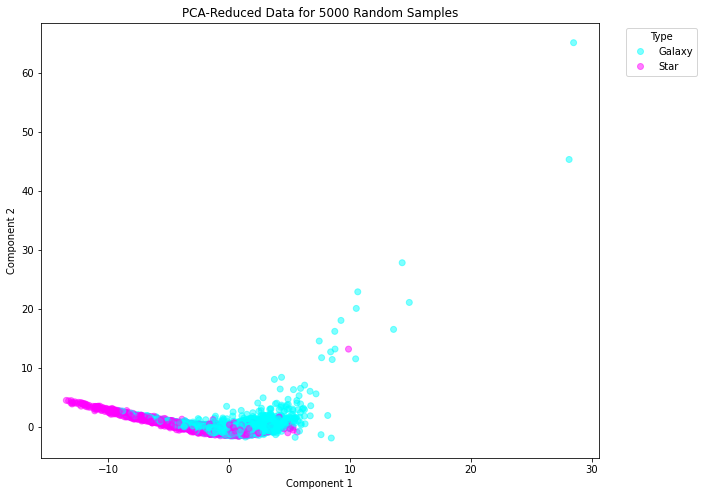

In [518]:
# Create scatterplot of PCA-reduced data for these 5000 random samples
# Colored by corresponding type

sample_fit = pca.fit_transform(X[rand])
sample_labels = labels[rand]

fig, ax = plt.subplots(figsize=(10,8))
scatter = plt.scatter(sample_fit[:,0], sample_fit[:,1], alpha=0.5, 
                      c=sample_labels, cmap='cool')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA-Reduced Data for 5000 Random Samples')
plt.legend(scatter.legend_elements()[0], ['Galaxy', 'Star'], title="Type", 
           bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

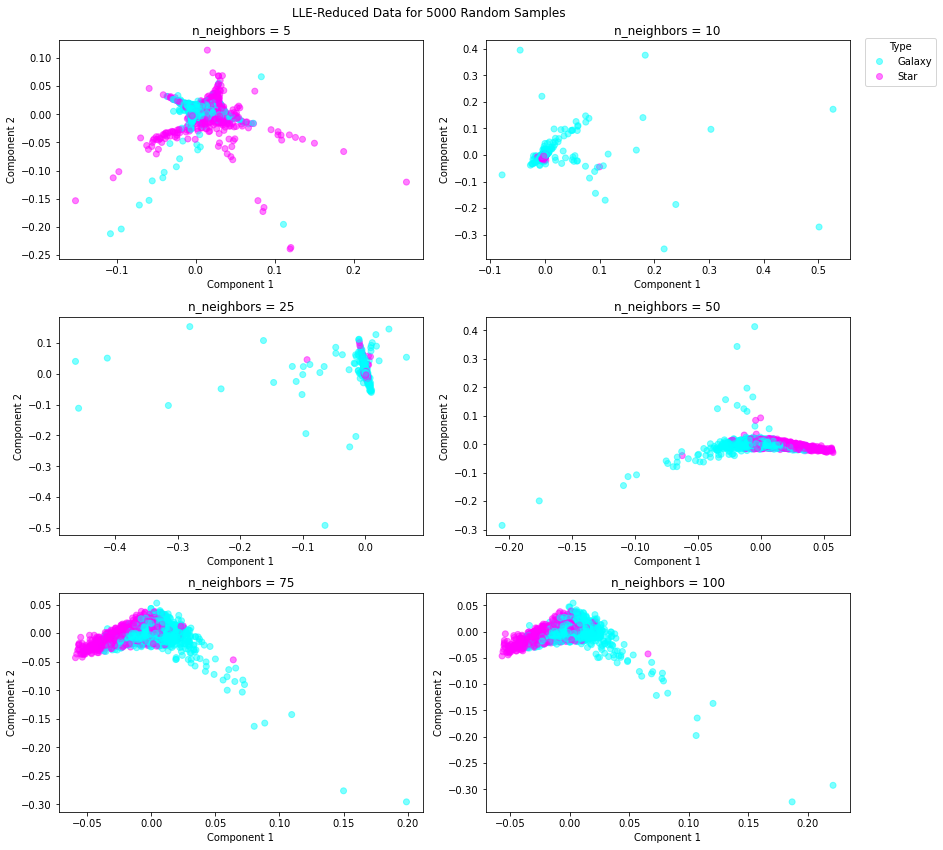

In [519]:
# Step 5
# Non-linear Dimensional Reduction
# 1. LocallyLinearEmbedding

# Figure with 2 rows and 3 columns
fig, ax = plt.subplots(3, 2, figsize=(12,12))

# Different values for n_neighbors to test
neighbors = [5, 10, 25, 50, 75, 100]
count = 0

for i in range(3):
    for j in range(2):
    
        # Create model
        n_neighbors = neighbors[count]
        lle = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors)

        # Train model with data
        lle_fit = lle.fit_transform(X[rand])

        # Plot
        ax[i][j].scatter(lle_fit[:,0], lle_fit[:,1], alpha=0.5, 
                         c=sample_labels, cmap='cool')
        ax[i][j].set_xlabel('Component 1')
        ax[i][j].set_ylabel('Component 2')
        ax[i][j].set_title(f'n_neighbors = {n_neighbors}')
        
        # Increment count to get next value of n_neighbors
        count += 1
        
fig.legend(scatter.legend_elements()[0], ['Galaxy', 'Star'], title="Type", 
           bbox_to_anchor=(1,0.95), loc="upper left")
fig.suptitle('LLE-Reduced Data for 5000 Random Samples')
plt.tight_layout()
plt.show()

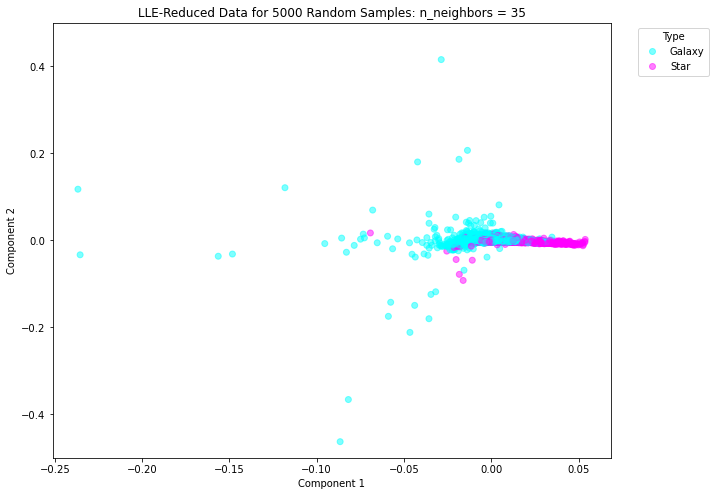

In [560]:
# Bigger plot for experimenting with n_neighbors value

#35
n_neighbors = 35
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=n_neighbors)

# Train model with data
lle_fit = lle.fit_transform(X[rand])

# Plot
fig, ax = plt.subplots(figsize=(10,8))
scatter = plt.scatter(lle_fit[:,0], lle_fit[:,1], alpha=0.5, c=sample_labels, cmap='cool')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.ylim(-0.5, 0.5)
plt.title(f'LLE-Reduced Data for 5000 Random Samples: n_neighbors = {n_neighbors}')
plt.legend(scatter.legend_elements()[0], ['Galaxy', 'Star'], title="Type", 
           bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

###### LLE:  After assigning the n_neighbors variable to various values between 5 and 100, I think that the best separation for this particular sample is given by around 35 nearest neighbors. The groupings of each type are pretty clear without a huge amount of overlap.

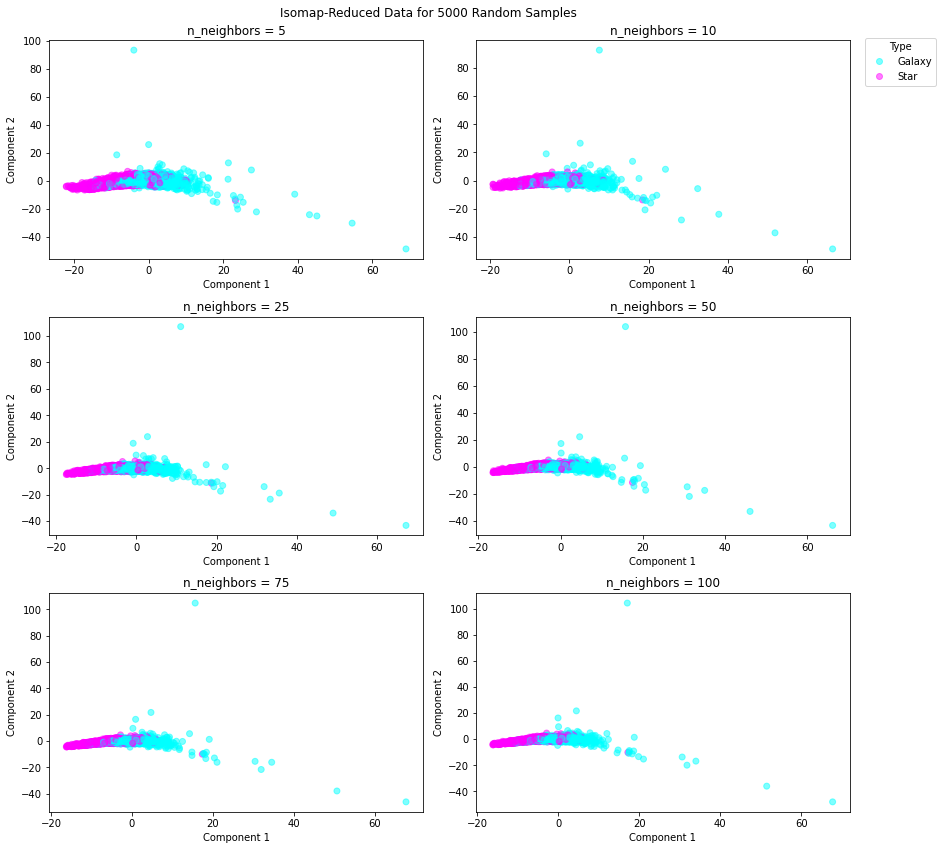

In [523]:
# 2. Isomap

# Figure with 2 rows and 3 columns
fig, ax = plt.subplots(3, 2, figsize=(12,12))

count = 0

for i in range(3):
    for j in range(2):
    
        # Create model
        n_neighbors = neighbors[count]
        iso = Isomap(n_components=2, n_neighbors=n_neighbors)

        # Train model with data
        iso_fit = iso.fit_transform(X[rand])

        # Plot
        scatter = ax[i][j].scatter(iso_fit[:,0], iso_fit[:,1], alpha=0.5, 
                                   c=sample_labels, cmap='cool')
        ax[i][j].set_xlabel('Component 1')
        ax[i][j].set_ylabel('Component 2')
        ax[i][j].set_title(f'n_neighbors = {n_neighbors}')
        
        # Increment count to get next value of n_neighbors
        count += 1
        
fig.legend(scatter.legend_elements()[0], ['Galaxy', 'Star'], title="Type", 
           bbox_to_anchor=(1,0.95), loc="upper left")
fig.suptitle('Isomap-Reduced Data for 5000 Random Samples')
plt.tight_layout()
plt.show()

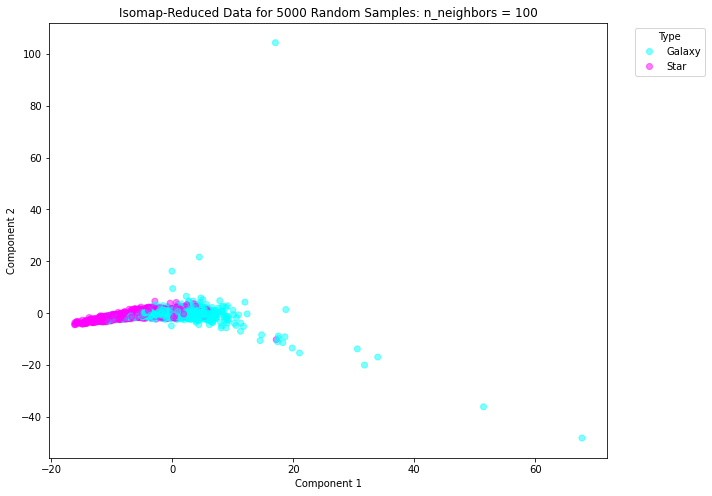

In [566]:
# Bigger plot for experimenting with n_neighbors value

n_neighbors = 100
iso = Isomap(n_components=2, n_neighbors=n_neighbors)

# Train model with data
iso_fit = iso.fit_transform(X[rand])

# Plot
fig, ax = plt.subplots(figsize=(10,8))
scatter = plt.scatter(iso_fit[:,0], iso_fit[:,1], alpha=0.5, c=sample_labels, cmap='cool')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'Isomap-Reduced Data for 5000 Random Samples: n_neighbors = {n_neighbors}')
plt.legend(scatter.legend_elements()[0], ['Galaxy', 'Star'], title="Type", 
           bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

###### Isomap: After assigning the n_neighbors variable to various values between 5 and 100, it's clear that the plots for each model look very similar to each other. For any value of n_neighbors, there appear to be discernible sections for each type with some amount of overlap. If I had to pick one that I thought did the best job, it would probably be around 100 nearest neighbors. The data seems the most condensed and with the least amount of interlap between types. However, since the plots are so similar, I think any value of n_neighbors would work similarly well.

###### I notice that these plots kind of resemble the plots for higher values of n_neighbors using the LLE algorithm. Another thing I notice is that the "line" of datapoints gets thinner as n_neighbors increases.

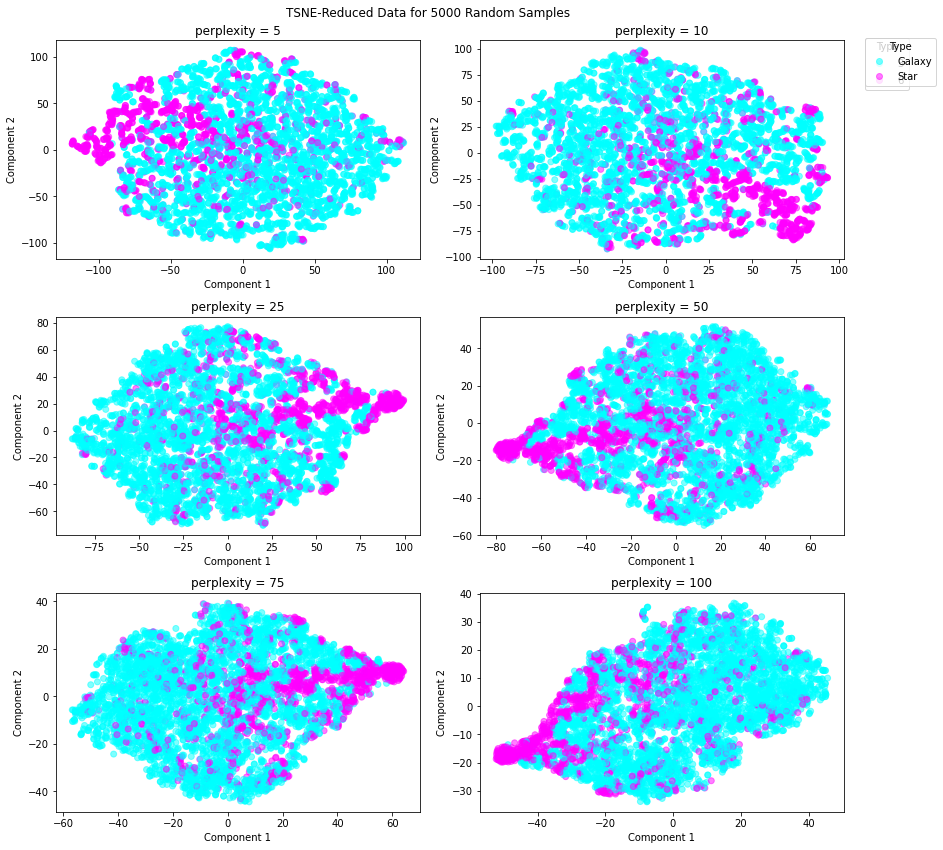

In [525]:
# 3. TSNE

# Figure with 2 rows and 3 columns
fig, ax = plt.subplots(3, 2, figsize=(12,12))

count = 0

for i in range(3):
    for j in range(2):
    
        # Create model
        perp = neighbors[count]
        tsne = TSNE(n_components=2, perplexity=perp)

        # Train model with data
        tsne_fit = tsne.fit_transform(X[rand])

        # Plot
        scatter = ax[i][j].scatter(tsne_fit[:,0], tsne_fit[:,1], alpha=0.5, 
                                   c=sample_labels, cmap='cool')
        ax[i][j].set_xlabel('Component 1')
        ax[i][j].set_ylabel('Component 2')
        ax[i][j].set_title(f'perplexity = {perp}')
        
        # Increment count to get next value of n_neighbors
        count += 1
        
fig.legend(*scatter.legend_elements(), title="Type", bbox_to_anchor=(1,0.95),
                   loc="upper left")
fig.legend(scatter.legend_elements()[0], ['Galaxy', 'Star'], title="Type", 
           bbox_to_anchor=(1,0.95), loc="upper left")
fig.suptitle('TSNE-Reduced Data for 5000 Random Samples')
plt.tight_layout()
plt.show()

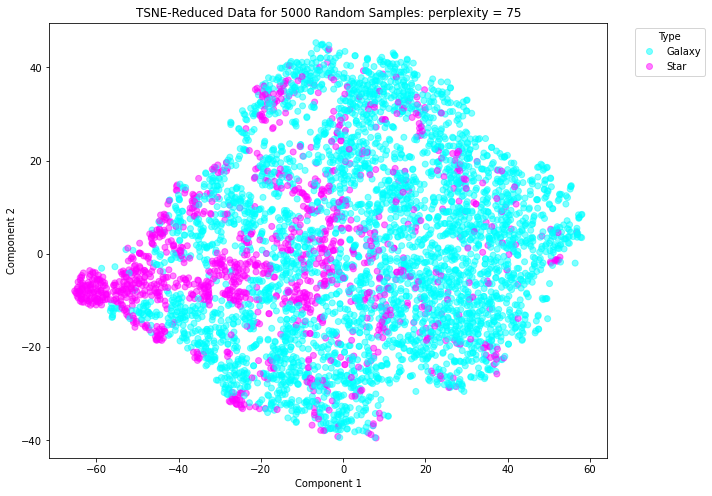

In [572]:
# Bigger plot for experimenting with perplexity value

perp = 75
tsne = TSNE(n_components=2, perplexity=perp)

# Train model with data
tsne_fit = tsne.fit_transform(X[rand])

# Plot
fig, ax = plt.subplots(figsize=(10,8))
scatter = plt.scatter(tsne_fit[:,0], tsne_fit[:,1], alpha=0.5,
                      c=sample_labels, cmap='cool')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'TSNE-Reduced Data for 5000 Random Samples: perplexity = {perp}')
plt.legend(scatter.legend_elements()[0], ['Galaxy', 'Star'], title="Type", 
           bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

###### TSNE: It appears that no particular value for perplexity gives a very good separation. The types in these plots are very interspersed with each other. It's interesting that in all of the plots, there seems to be a "corner" that's predominantly Type 6 (Star). If I had to pick a value for the best perplexity, it would perhaps be around 65-75. These plots don't look particularly different from any of the others, but visually-speaking, they might have more concentration in their pink "corner."

###### Based on this particular sample, I think that the Isomap algorithm most consistently gives the cleanest way to visualize the two populations (galaxies and stars). LLE does the second-best job depending on the value of n_neighbors, and I would rank TSNE last.

###### It's important to note that the plots for each algorithm looked very different depending on the random sample I used and even based on randomization within the algorithm. The observations made above will not apply to every case of execution.